<a href="https://colab.research.google.com/github/ManithSoun/munchy-ai-recipe-generator/blob/main/munchy_recipe_generator_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Datasets Path

In [ ]:
image_dataset = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco"
all_files = os.listdir(image_dataset)

print(f"Total files in folder: {len(all_files)}\n")

# Show the first 10 filenames
for i, f in enumerate(all_files[:10]):
    print(f"[{i}] {f}")

Total files in folder: 5

[0] README.roboflow.txt
[1] README.dataset.txt
[2] test
[3] valid
[4] train


In [ ]:
!ls "/content/drive/MyDrive/AI Recipe Final Project"

 cleaned_dataset.csv		      full_dataset.csv	 y_labels.npy
'FOOD-INGREDIENTS dataset.v2i.coco'   X_images.npy


## **1. Image Dataset Preprocessing**

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
image_dataset = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco"


create preprocessing function

In [ ]:
def preprocessing_images_flat(img_folder, size=(224, 224)):
    X = []
    filenames = [f for f in os.listdir(img_folder)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in tqdm(filenames, desc="Processing images"):
        img_path = os.path.join(img_folder, img_file)
        img = cv2.imread(img_path)

        if img is not None:
            # Handle grayscale or RGBA images
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[2] == 4:
                img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize and normalize
            img = cv2.resize(img, size)
            img = img / 255.0
            X.append(img)
        else:
            print(f"Skipped: {img_path}")

    return np.array(X)

In [ ]:
train_path = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco/train"
valid_path = "/content/drive/MyDrive/AI Recipe Final Project/FOOD-INGREDIENTS dataset.v2i.coco/valid"

Run the preprocessing

In [ ]:
X_train = preprocessing_images_flat(train_path)
X_valid = preprocessing_images_flat(valid_path)

print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)

Processing images: 100%|██████████| 829/829 [00:14<00:00, 56.64it/s]


X_train shape: (2791, 224, 224, 3)
X_valid shape: (829, 224, 224, 3)


Avoding reprocessing each time

In [ ]:
np.save("/content/drive/MyDrive/AI Recipe Final Project/X_train.npy", X_train)
np.save("/content/drive/MyDrive/AI Recipe Final Project/X_valid.npy", X_valid)

# Show 5 random samples

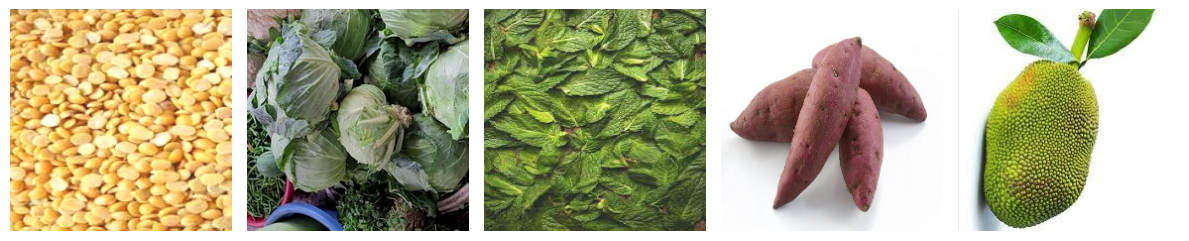

In [ ]:
plt.figure(figsize=(12,6))
for i in range(5):
    index = np.random.randint(0, len(X_train))
    img = X_train[index]

    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

## **2. Text Dataset Preprocessing**

In [ ]:
import pandas as pd
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
text_dataset = pd.read_csv("/content/drive/MyDrive/AI Recipe Final Project/full_dataset.csv")
text_dataset.head(10)

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."
5,5,Cheeseburger Potato Soup,"[""6 baking potatoes"", ""1 lb. of extra lean gro...","[""Wash potatoes; prick several times with a fo...",www.cookbooks.com/Recipe-Details.aspx?id=20115,Gathered,"[""baking potatoes"", ""extra lean ground beef"", ..."
6,6,Rhubarb Coffee Cake,"[""1 1/2 c. sugar"", ""1/2 c. butter"", ""1 egg"", ""...","[""Cream sugar and butter."", ""Add egg and beat ...",www.cookbooks.com/Recipe-Details.aspx?id=210288,Gathered,"[""sugar"", ""butter"", ""egg"", ""buttermilk"", ""flou..."
7,7,Scalloped Corn,"[""1 can cream-style corn"", ""1 can whole kernel...","[""Mix together both cans of corn, crackers, eg...",www.cookbooks.com/Recipe-Details.aspx?id=876969,Gathered,"[""cream-style corn"", ""whole kernel corn"", ""cra..."
8,8,Nolan'S Pepper Steak,"[""1 1/2 lb. round steak (1-inch thick), cut in...","[""Roll steak strips in flour."", ""Brown in skil...",www.cookbooks.com/Recipe-Details.aspx?id=375254,Gathered,"[""tomatoes"", ""water"", ""onions"", ""Worcestershir..."
9,9,Millionaire Pie,"[""1 large container Cool Whip"", ""1 large can c...","[""Empty Cool Whip into a bowl."", ""Drain juice ...",www.cookbooks.com/Recipe-Details.aspx?id=794547,Gathered,"[""pineapple"", ""condensed milk"", ""lemons"", ""pec..."


**Remove the last three columns**

In [ ]:
data = text_dataset.iloc[:, :-3]  # Keep only the first four columns
data.columns = ["No", "Recipe", "Ingredients", "Instructions"]
data.head(10)

,No,Recipe,Ingredients,Instructions
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish...."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ..."
5,5,Cheeseburger Potato Soup,"[""6 baking potatoes"", ""1 lb. of extra lean gro...","[""Wash potatoes; prick several times with a fo..."
6,6,Rhubarb Coffee Cake,"[""1 1/2 c. sugar"", ""1/2 c. butter"", ""1 egg"", ""...","[""Cream sugar and butter."", ""Add egg and beat ..."
7,7,Scalloped Corn,"[""1 can cream-style corn"", ""1 can whole kernel...","[""Mix together both cans of corn, crackers, eg..."
8,8,Nolan'S Pepper Steak,"[""1 1/2 lb. round steak (1-inch thick), cut in...","[""Roll steak strips in flour."", ""Brown in skil..."
9,9,Millionaire Pie,"[""1 large container Cool Whip"", ""1 large can c...","[""Empty Cool Whip into a bowl."", ""Drain juice ..."


**Check for duplicate rows**

In [ ]:
# Check for duplicate rows
duplicate_rows = data[data.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Show the duplicate rows (if any)
if not duplicate_rows.empty:
    print("\nDuplicate Rows Found:\n", duplicate_rows)
else:
    print("\nNo duplicate rows found in the dataset.")

print(f"Total number of rows in the dataset: {data.shape[0]}")

Number of duplicate rows: 0

No duplicate rows found in the dataset.
Total number of rows in the dataset: 2231142


**Check for missing values and remove rows with missing data**

In [ ]:
missing_rows = data[data.isnull().any(axis=1)]
print(f"Rows with missing values: {missing_rows.shape[0]}")
data = data.dropna()

# Print the number of rows after removal
print(f"Rows after removing missing values: {data.shape[0]}")

Rows with missing values: 1
Rows after removing missing values: 2231141


**Clean text data by removing stopwords, punctuation, and lemmatizing words**

In [ ]:
# lemmatizer = WordNetLemmatizer()

**Function to preprocess the text (remove punctuation, lowercasing, tokenization, and lemmatization)**

In [ ]:
# def preprocess_text(text):
#     text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
#     text = text.lower()  # Lowercase the text
#     tokens = word_tokenize(text) # Tokenize the text
#     text = ' '.join([lemmatizer.lemmatize(word) for word in tokens]) # Lemmatize each token
#     return text

**Apply the preprocessing function to both 'Ingredients' and 'Instructions'**

In [ ]:
# Display cleaned dataset
print("\nCleaned Dataset:\n", data.head())


Cleaned Dataset:
    No                 Recipe  \
0   0    No-Bake Nut Cookies   
1   1  Jewell Ball'S Chicken   
2   2            Creamy Corn   
3   3          Chicken Funny   
4   4   Reeses Cups(Candy)     

                                         Ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["1 small jar chipped beef, cut up", "4 boned ...   
2  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
3  ["1 large whole chicken", "2 (10 1/2 oz.) cans...   
4  ["1 c. peanut butter", "3/4 c. graham cracker ...   

                                        Instructions  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["Place chipped beef on bottom of baking dish....  
2  ["In a slow cooker, combine all ingredients. C...  
3  ["Boil and debone chicken.", "Put bite size pi...  
4  ["Combine first four ingredients and press in ...  
